<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/5/lab.ipynb">link</a>

Authorize google + kaggle

In [25]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


Be sure, that we authorized and have an access to kaggle

In [26]:
%ls /content/.kaggle/

kaggle.json*


# **Part 1: Download dataset, extract, split, check data distribution**

In [27]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download  -c dogs-vs-cats -p /content/kaggle/dogscats

mkdir: cannot create directory ‘/root/.kaggle’: File exists
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


Extract .zip


In [0]:
!unzip kaggle/dogscats/train.zip -d train
!unzip kaggle/dogscats/test1.zip -d test

In [28]:
%ls

adc.json  kaggle/  sample_data/  submission.csv  test/  train/


In [29]:
import pandas as pd
import os

TRAIN_PATH = './train/train'
TEST_PATH = './test/test1'

filenames = os.listdir(TRAIN_PATH)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
df.head()

,filename,category
0,cat.2910.jpg,cat
1,cat.3176.jpg,cat
2,cat.6647.jpg,cat
3,dog.1106.jpg,dog
4,cat.6265.jpg,cat


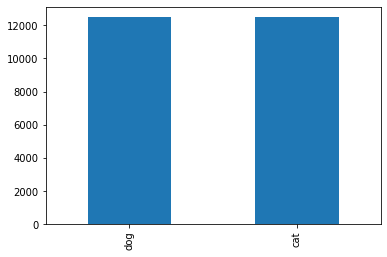

In [0]:
df['category'].value_counts().plot.bar()

Train/Dev split


In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.20, random_state=42)

Check data distribution

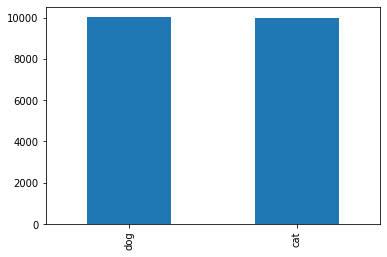

In [0]:
train['category'].value_counts().plot.bar()

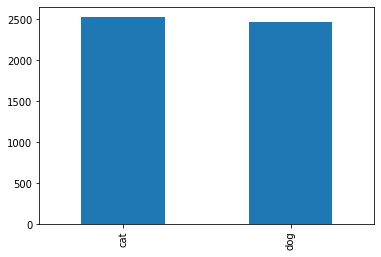

In [0]:
val['category'].value_counts().plot.bar()

Use `ImageDataGenerator` in order to reduce data memory consumption (just with rescaling for improving speed of learning)

In [31]:
from keras.preprocessing.image import ImageDataGenerator, load_img

# train
train_datagen = ImageDataGenerator(rescale=1./255)

total_train = train.shape[0]
total_validate = val.shape[0]
batch_size = 32  # since Andrew Ng told, that better use 2^n

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

train_generator = train_datagen.flow_from_dataframe(
    train, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    val, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


And the same processing for test set:

In [32]:
test_filenames = os.listdir(TEST_PATH)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    TEST_PATH, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# **Part 2: DNN architecture**

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 classes: dog and cat

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

model.save_weights('initial.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)       

In [34]:
model.load_weights('initial.h5')
history = model.fit_generator(
    train_generator, 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/30
625/625 [==============================] - 70s 112ms/step - loss: 0.7187 - acc: 0.6778 - val_loss: 0.5629 - val_acc: 0.7202
Epoch 2/30
625/625 [==============================] - 69s 110ms/step - loss: 0.4611 - acc: 0.7826 - val_loss: 0.7389 - val_acc: 0.7122
Epoch 3/30
625/625 [==============================] - 69s 111ms/step - loss: 0.3909 - acc: 0.8258 - val_loss: 0.3826 - val_acc: 0.8313
Epoch 4/30
625/625 [==============================] - 69s 110ms/step - loss: 0.3005 - acc: 0.8731 - val_loss: 0.5113 - val_acc: 0.8064
Epoch 6/30
625/625 [==============================] - 69s 111ms/step - loss: 0.2675 - acc: 0.8882 - val_loss: 0.4164 - val_acc: 0.8090
Epoch 7/30
625/625 [==============================] - 69s 110ms/step - loss: 0.2431 - acc: 0.9012 - val_loss: 0.5699 - val_acc: 0.8092
Epoch 8/30
625/625 [==============================] - 69s 110ms/step - loss: 0.2180 - acc: 0.9139 - val_loss: 0.4090 - val_acc: 0.8255
Epoch 9/30
625/625 [==============================] - 6

# **Part 3: Add data augmentation**

In [35]:
train_datagen_aug = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator_aug = train_datagen_aug.flow_from_dataframe(
    train, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


And train NN again

In [36]:
model.load_weights('initial.h5')
history_aug = model.fit_generator(
    train_generator_aug, 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/30
625/625 [==============================] - 131s 209ms/step - loss: 0.7658 - acc: 0.6423 - val_loss: 0.5819 - val_acc: 0.6875
Epoch 2/30
625/625 [==============================] - 128s 205ms/step - loss: 0.5294 - acc: 0.7419 - val_loss: 0.4447 - val_acc: 0.7925
Epoch 3/30
625/625 [==============================] - 129s 206ms/step - loss: 0.4713 - acc: 0.7805 - val_loss: 0.5107 - val_acc: 0.7500
Epoch 4/30
625/625 [==============================] - 129s 206ms/step - loss: 0.4306 - acc: 0.8026 - val_loss: 0.4313 - val_acc: 0.8078
Epoch 5/30
625/625 [==============================] - 127s 203ms/step - loss: 0.4044 - acc: 0.8173 - val_loss: 0.4806 - val_acc: 0.7838
Epoch 6/30
625/625 [==============================] - 127s 204ms/step - loss: 0.3865 - acc: 0.8282 - val_loss: 0.3588 - val_acc: 0.8436
Epoch 7/30
625/625 [==============================] - 130s 207ms/step - loss: 0.3672 - acc: 0.8380 - val_loss: 0.3343 - val_acc: 0.8617
Epoch 8/30
625/625 [============================

# **Part 4: using VGG16**



Define model

In [0]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

# load model
vgg = VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
# mark loaded layers as not trainable
for layer in vgg.layers:
	layer.trainable = False

# define a new output layer to connect with the last fc layer in vgg
x = Flatten()(vgg.layers[-1].output)
class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
bn = BatchNormalization()(class1)
do = Dropout(0.5)(bn)
output_layer = Dense(2, activation='softmax', name='predictions')(do)

# combine the original VGG model with the new output layer
vgg = Model(inputs=vgg.input, outputs=output_layer)

vgg.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

history_vgg = vgg.fit_generator(
    train_generator_aug, 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/30
625/625 [==============================] - 136s 217ms/step - loss: 0.3982 - acc: 0.8335 - val_loss: 0.4179 - val_acc: 0.8173
Epoch 2/30
625/625 [==============================] - 133s 213ms/step - loss: 0.3186 - acc: 0.8579 - val_loss: 0.2939 - val_acc: 0.8676
Epoch 3/30
625/625 [==============================] - 133s 212ms/step - loss: 0.3087 - acc: 0.8661 - val_loss: 0.2499 - val_acc: 0.8937
Epoch 4/30
625/625 [==============================] - 134s 215ms/step - loss: 0.2974 - acc: 0.8723 - val_loss: 0.2387 - val_acc: 0.8939
Epoch 5/30
625/625 [==============================] - 133s 213ms/step - loss: 0.2922 - acc: 0.8712 - val_loss: 0.2548 - val_acc: 0.8893
Epoch 6/30
625/625 [==============================] - 134s 214ms/step - loss: 0.2930 - acc: 0.8721 - val_loss: 0.2307 - val_acc: 0.9024
Epoch 7/30
625/625 [==============================] - 133s 213ms/step - loss: 0.2872 - acc: 0.8763 - val_loss: 0.2348 - val_acc: 0.9004
Epoch 8/30
625/625 [============================

Save model

In [0]:
vgg.save_weights('vgg16-v1.h5')

And download it

In [0]:
from google.colab import files
files.download('vgg16-v1.h5')

# **Part 5: Kaggle results**

In [0]:
import numpy as np

predict = vgg.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [0]:
# For categoral classication the prediction will come with probability of each category.
# So we will pick the category that have the highest probability with numpy average max
test_df['category'] = np.argmax(predict, axis=-1)

In [0]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

Visualize Result

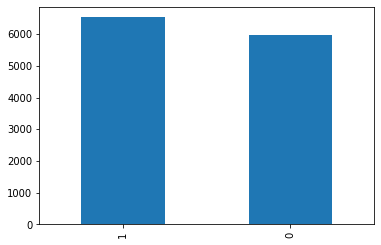

In [0]:
test_df['category'].value_counts().plot.bar()

Write predicted values to `submission.csv`

In [0]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

Download `submission.csv` file

In [0]:
files.download('submission.csv')